# Capstone Project: African Dining in London

## 1.Introduction

### 1.1 Description

Considering how diverse the city of London is, it can be difficult to find nice African dining experiences. This project will try to find the best spots within London for opening a new restaurant for African Cuisine. This will mainly target African (black) people and as such will focus on the demographics of London for finding a spot.

### 1.2 Background

If anyone wanted to start an African restaurant in London, what would be the best place to establish it? An African restaurant could be anything from Nigerian to Ghanese to Ethiopian.
Could we, based on the demographics of different areas in london, Determine which area would be the best to open a new restaurant?

## 2.Data

### 2.1 Description

In this notebook, we will focus on the data from 2 sources, the [Demography of London](https://en.wikipedia.org/wiki/Demography_of_London) and [Areas of London](https://en.wikipedia.org/wiki/List_of_areas_of_London), both from WikiPedia, and the venue data from Foursquare.

#### 2.1.1 London Areas Data

##### Importing the Libraries.

In [1]:
# BeautifulSoup library
from bs4 import BeautifulSoup

# Numpy library
import numpy as np

# Panda Library
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# JSON file library
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# install Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
folium installed...
folium imported...
...Done


In [ ]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

In [3]:
# Cleaning the HTML file
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
# Extracting "tbody" within table with class: "wikitable sortable"
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [4]:
# Extracting all "tr" (table rows) within above table
rows = table.find_all('tr')

In [5]:
# Extracting column headers, removing and replacing possible '\n' with space for "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]

In [6]:
# Converting columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [7]:
# Extracting every row with corresponding columns
# Appending the values to the create pd dataframe "df"
# Skipping 1st row since it already is a header
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [8]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [9]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [10]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [11]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [12]:
df.shape

(533, 6)

In [13]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Considering there is a limit in calls for the Foursquare API, we will work with some speculation in the following actions. 

For starters, where the Postcode are more than one, the postcodes are spread to multi-rows and assigned the same values from the other columns.


In [14]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [15]:
df0.head(5)

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [16]:
df0.shape

(637, 6)

From the data, only the 'Location', 'Borough', 'Postcode', 'Post-town' will be used for this project. So they are extracted into a new data frame.

In [17]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [18]:
df1.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [19]:
df1.shape

(637, 4)

Now, only the Boroughs with London Post-town will be used for our search of location. Therefore, all the non-post-town are dropped.

In [20]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [21]:

df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [22]:
df21.shape

(381, 4)

there are now 381 instances instead of 637 because of the drop of non-London post-towns.

In [23]:
# Re-assigns the df21 to new dataframe without the Post-town
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [24]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [25]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

Because of the diversity and proximity to afro-caribbean markets and facilities, only the South East areas of London will be used for this analysis. Postcodes there are starting with SE.

So we have to remove the whitesapaces at the start of some of the postcodes and then drop the other non-SE postcodes.

In [26]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [27]:
df_london.Postcode = df_london.Postcode.str.strip()

In [28]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [29]:
# New dataframe for South East London postcodes - df_se
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [30]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


Now we will focus on the demography of London to see where there are predominantly more multicultural groups. Based on the proportion of races per London borough, this is done by scraping the [Demography of London](https://en.wikipedia.org/wiki/Demography_of_London) page.


In [31]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [32]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [33]:

demo_london = pd.DataFrame(columns = columns1)

In [34]:
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [35]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [36]:
demo_london['Black'] = demo_london['Black'].astype('float')

In [37]:
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)

In [38]:
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


Now we find the top 5 areas with significantly high "Black", "Mixed" and other races. This leaves us with Lewisham, Southwark, Lambeth, Hackney and Croydon.

In [39]:
df_se

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [40]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [41]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [42]:
df_se_top.shape

(46, 3)

In [43]:
df_se.shape

(80, 3)

Now we have a dataframe to work with. Which is df_se_top.

#### 2.1.2 Geocoder Data

In obtaining the location data of the locations, the Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.

These will help to create a new dataframe that will be used subsequently for the South East London areas.

In [44]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

Testing with sample postcode - SE2.

In [45]:
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

Reverse geocoding this, using the geocodefarm geocoder results in:

In [46]:
gg = geocoder.geocodefarm(sample, method = 'reverse')
gg

<[FAILED, NO_RESULTS] Geocodefarm - Reverse [empty]>

In [47]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)


Time of execution:  37.14332699775696 seconds


Now we go to store the location data - latitude and longitude as follows. The obtained coordinates are then joined to df_se_top to create a new data frame.

In [48]:
df_se_loc = df_se_top

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [49]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [50]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)

In [51]:
df_se_loc.shape

(46, 5)

#### 2.1.3 Foursquare API Data

We use the Foursquare API to obtain South East London Area venues for the geographical location data . These will be then used to explore the neighbourhoods of London accordingly.

The venues within the neighbourhoods of South East London like the restaurants in the area and the proximity to amenities will be considered.

##### Define Foursquare Credentials

In [52]:
CLIENT_ID = 'HDXYES5MTVRX5XXKZLAQDME3ZRREZULV3EYZLMCQU1WDFDZK' # your Foursquare ID
CLIENT_SECRET = '1SHEEKXS1CW0FPCUXK33IDGO1AAQHMN4DH0XPIOABAQWVPLN' # your Foursquare Secret
VERSION = '20200606' # Foursquare API version

## 3. Methodology

### 3.1 Data exploration

#### 3.1.1 Individual area

The Lewisham Borough was used as an initial exploration to examine the workability with Foursquare.

In [53]:
# Resets the current index to a new
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [54]:
se_df.shape

(46, 5)

In [55]:
se_df

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076
5,Elephant and Castle,Southwark,SE1,51.49996,-0.09568
6,Elephant and Castle,Southwark,SE11,51.49084,-0.11108
7,Elephant and Castle,Southwark,SE17,51.48764,-0.09542
8,Bankside,Southwark,SE1,51.49996,-0.09568
9,Forest Hill,Lewisham,SE23,51.44122,-0.04764


In [56]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


Now we use the Lewisham with the index location 20.

In [57]:
se_df.loc[20, 'Location']

'Lewisham'

In [58]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))

The latitude and longitude values of Lewisham with postcode SE13, are 51.46196000000003, -0.007539999999949032.


Now we will take a look at the top 100 venues within a 2km radius of Lewisham.

Then we create the GET request URL, and then the url is named.

In [59]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id=HDXYES5MTVRX5XXKZLAQDME3ZRREZULV3EYZLMCQU1WDFDZK&client_secret=1SHEEKXS1CW0FPCUXK33IDGO1AAQHMN4DH0XPIOABAQWVPLN&v=20200606&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=HDXYES5MTVRX5XXKZLAQDME3ZRREZULV3EYZLMCQU1WDFDZK&client_secret=1SHEEKXS1CW0FPCUXK33IDGO1AAQHMN4DH0XPIOABAQWVPLN&v=20200606&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

In [60]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee3d149e5ec386ad306212a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lewisham Central',
  'headerFullLocation': 'Lewisham Central, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 187,
  'suggestedBounds': {'ne': {'lat': 51.47996001800005,
    'lng': 0.021296961190459426},
   'sw': {'lat': 51.44395998200002, 'lng': -0.03637696119035749}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535823bc498ec8d8da9aad5f',
       'name': 'Street Feast Model Market',
       'location': {'address': '196 Lewisham High St',
        'crossStreet': 'entrance at Molesworth St',
        'lat': 51.46020945743763,
        'lng': -0.01

From these results, the necessary information needs to be obtained from the items key. To do this, the get_category_type function is used from the Foursquare lab.

In [61]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The result is then cleaned up from json to a structured pandas dataframe as shown below:

In [62]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [63]:
nearby_venues

,name,categories,lat,lng
0,Street Feast Model Market,Street Food Gathering,51.460209,-0.012199
1,Maggie's Kitchen,Café,51.465380,-0.011213
2,Gennaro Delicatessan,Deli / Bodega,51.461765,-0.009726
3,Levante restaurant,Restaurant,51.462072,-0.009491
4,Dirty South,Pub,51.458846,-0.002666
5,Levante Pide Restaurant,Turkish Restaurant,51.459848,-0.011476
6,Corte,Coffee Shop,51.459776,-0.011554
7,Manor House Gardens,Park,51.456686,0.004684
8,The Sausage Man,Food Truck,51.462507,-0.010248
9,Côte Brasserie,French Restaurant,51.467378,0.007176


In [64]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [65]:
nearby_venues_lewisham_unique.head(5)

,Count
Pub,13
Café,8
Park,6
Gastropub,5
Garden,4


In [66]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### 3.1.2 Multiple areas

We create the function getNearbyVenues to repeat the same process for all neighborhoods.

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We use the function on all neighbourhoods and create a new dataframe called london_venues.

In [69]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [70]:
se_venues.shape

(4246, 7)

In [71]:
len(se_venues)

4246

In [72]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [73]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
2,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant
3,Crofton Park,51.46268,-0.03558,Masala Wala,51.465652,-0.036007,Pakistani Restaurant
4,Crofton Park,51.46268,-0.03558,Waterintobeer,51.463712,-0.038826,Beer Store


In [74]:
se_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bankside,100,100,100,100,100,100
Bellingham,69,69,69,69,69,69
Bermondsey,100,100,100,100,100,100
Blackheath,95,95,95,95,95,95
Brixton,100,100,100,100,100,100
Brockley,100,100,100,100,100,100
Camberwell,100,100,100,100,100,100
Catford,69,69,69,69,69,69
Chinbrook,59,59,59,59,59,59


In [75]:
print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))

There are 195 uniques categories.


In [76]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')

In [77]:
se_venue_unique_count.head(5)

,Count
Pub,409
Coffee Shop,327
Café,272
Park,242
Grocery Store,165


In [78]:
se_venue_unique_count.describe()

,Count
count,195.000000
mean,21.774359
std,48.845120
min,1.000000
25%,4.000000
50%,8.000000
75%,17.000000
max,409.000000


### 3.2 Clustering

Now we will cluster the neighbourhoods in South East London based on the processed data obtained.

#### 3.2.1 Map Visualization

We use the geopy library, to obtain the latitude and longitude values of London.

In [79]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


Then we use Folium to obtain the coordinates.

In [80]:
# df_london_coordinates
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

South East London neighbourhoods are then superimposed on top.

In [81]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [82]:
type(se_df)

pandas.core.frame.DataFrame

#### 3.2.2 Analysing all areas

##### One Hot Encoding

In [83]:
# one hot encoding
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [84]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [85]:
# move neighborhood column to the first column
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [86]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [87]:
se_onehot.loc[se_onehot['African Restaurant'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
140,Denmark Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
616,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
707,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [88]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1877,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1878,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1879,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Looks like Lewisham has no African restaurants within the top spots.

In [89]:
se_onehot.to_csv('selondon_onehot.csv', index = False)

In [90]:
se_onehot.shape

(4246, 196)

##### Regrouping and Category Statistics

In [91]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.000000,0.0,0.0,0.000000,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.020000,0.000000,0.00,0.0,0.00,0.01,0.0,0.0,0.000000,0.0,0.010000,0.00,0.02,0.000000,0.010000,0.0,0.0,0.0,0.01,0.000000,0.0,0.0,0.000000,0.050000,0.100000,0.00,0.000000,0.01,0.000000,0.00,0.0,0.000000,0.02,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.01,0.0,0.00,0.0,0.00,0.0,0.010000,0.000000,0.00,0.0,0.0,0.0,0.01,0.00,0.01,0.0,0.0,0.020000,0.000000,0.01,0.000000,0.00,0.020000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.040000,0.000000,0.020000,0.0,0.0,0.000000,0.000000,0.000000,0.01,0.0,0.070000,0.0,0.0,0.010000,0.0,0.000000,0.000000,0.020000,0.000000,0.0,0.01,0.00,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.01,0.01,0.0,0.01,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.030000,0.0,0.0,0.01,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.020000,0.040000,0.0,0.00,0.00,0.000000,0.0,0.010000,0.000000,0.0,0.0,0.010000,0.05,0.0,0.02,0.000000,0.000000,0.01,0.0,0.000000,0.01,0.0,0.000000,0.0,0.0,0.0,0.03,0.000000,0.0,0.0,0.020000,0.0,0.000000,0.070000,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0.0,0.01,0.000000,0.0,0.020000,0.0,0.00,0.00,0.000000
1,Bellingham,0.0

In [92]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (46, 5)
After One-hot encoding: (40, 196)


In [93]:
se_grouped.to_csv('london_grouped.csv', index = False)

In [94]:
num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                   venue  freq
0            Coffee Shop  0.10
1                  Hotel  0.07
2                Theater  0.07
3           Cocktail Bar  0.05
4         Scenic Lookout  0.05
5                    Pub  0.04
6          Grocery Store  0.04
7  Street Food Gathering  0.03
8                   Park  0.03
9   Gym / Fitness Center  0.02


----Bellingham----
                  venue  freq
0         Grocery Store  0.14
1           Supermarket  0.09
2                  Park  0.09
3                   Pub  0.06
4                  Café  0.04
5  Fast Food Restaurant  0.04
6    Italian Restaurant  0.04
7           Coffee Shop  0.04
8        Hardware Store  0.03
9         Train Station  0.03


----Bermondsey----
                   venue  freq
0            Coffee Shop  0.10
1                  Hotel  0.07
2                Theater  0.07
3           Cocktail Bar  0.05
4         Scenic Lookout  0.05
5                    Pub  0.04
6          Grocery Store  0.04
7  Street Food Gatheri

                venue  freq
0         Coffee Shop  0.10
1                Café  0.06
2             Theater  0.05
3               Hotel  0.05
4                Park  0.05
5        Cocktail Bar  0.04
6                 Pub  0.04
7  Italian Restaurant  0.04
8       Grocery Store  0.03
9              Bakery  0.02


----Nunhead----
                venue  freq
0                 Pub  0.11
1                Café  0.08
2         Pizza Place  0.06
3                Park  0.05
4         Coffee Shop  0.05
5           Gastropub  0.04
6                 Bar  0.04
7  Italian Restaurant  0.03
8         Art Gallery  0.03
9        Cocktail Bar  0.03


----Oval----
                   venue  freq
0                   Café  0.14
1                    Pub  0.07
2                   Park  0.06
3                  Hotel  0.05
4                Theater  0.05
5            Coffee Shop  0.05
6     Italian Restaurant  0.03
7                 Garden  0.03
8            Art Gallery  0.02
9  Street Food Gathering  0.02


----Peck

##### Creating new dataframe:


Sorting the venues in descending order with return_most_common_venues

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Then we create a new panda dataframe with 10 most common venues:

In [96]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [97]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Coffee Shop,Theater,Hotel,Cocktail Bar,Scenic Lookout,Pub,Grocery Store,Street Food Gathering,Park,Portuguese Restaurant
1,Bellingham,Grocery Store,Park,Supermarket,Pub,Italian Restaurant,Coffee Shop,Café,Fast Food Restaurant,Hardware Store,Train Station
2,Bermondsey,Coffee Shop,Theater,Hotel,Cocktail Bar,Scenic Lookout,Pub,Grocery Store,Street Food Gathering,Park,Portuguese Restaurant
3,Blackheath,Pub,Park,Coffee Shop,Grocery Store,Supermarket,Italian Restaurant,Bakery,Café,Garden,Pizza Place
4,Brixton,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Grocery Store,Pizza Place,Cocktail Bar,Beer Bar


In [98]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [99]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

#### 3.2.3 Clustering of Areas

Now we create clusters of the neighbourhood using the k-means to cluster the neighbourhood into 5 clusters.

In [100]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 3, 2, 4, 1, 4, 0, 0, 1], dtype=int32)

In [101]:
kmeans.labels_[0:10]

array([3, 0, 3, 2, 4, 1, 4, 0, 0, 1], dtype=int32)

Then we create a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

In [102]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [103]:
se_merged = se_df

In [104]:
se_merged.head(3)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467


In [105]:
# match/merge SE London data with latitude/longitude for each neighborhood
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [106]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,1,Pub,Coffee Shop,Café,Park,Cocktail Bar,Gastropub,Pizza Place,Indian Restaurant,Bar,Italian Restaurant
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313,4,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Grocery Store,Pizza Place,Cocktail Bar,Beer Bar
2,Deptford,Lewisham,SE8,51.48114,-0.02467,2,Pub,Coffee Shop,Café,Bar,Park,Garden,Turkish Restaurant,Indian Restaurant,Indie Movie Theater,Brewery
3,Dulwich,Southwark,SE21,51.44100,-0.08897,2,Pub,Café,Park,Coffee Shop,Bakery,Grocery Store,Italian Restaurant,Brewery,Gym / Fitness Center,Farmers Market
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,4,Pub,Park,Café,Pizza Place,Italian Restaurant,Gym / Fitness Center,Forest,Coffee Shop,Platform,Bakery


In [107]:
se_clusters = se_merged_latlong

#### 3.2.4 Optimal Number of Clusters for K-mean

To get the optimal number of clusters to be used for the K-mean, there are a number of possible ways for the evaluation. Therefore, in this task, we use the Elbow Method and the Silhouette Coefficient.

##### 3.2.4.1 Elbow Method

In [108]:
%matplotlib inline
import matplotlib
import numpy as np

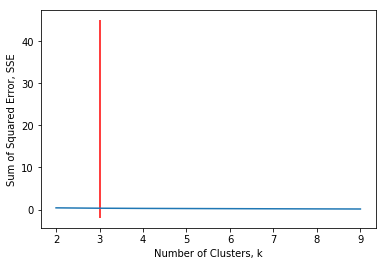

In [109]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

##### 3.2.4.2 Silhouette Coefficient

In [110]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.5626500498441525
Where n_clusters = 3, the Silhouette Coefficient is 0.6565102277089107
Where n_clusters = 4, the Silhouette Coefficient is 0.6657921800609576
Where n_clusters = 5, the Silhouette Coefficient is 0.7047701981494828
Where n_clusters = 6, the Silhouette Coefficient is 0.7413760362019454
Where n_clusters = 7, the Silhouette Coefficient is 0.7786761737088547
Where n_clusters = 8, the Silhouette Coefficient is 0.8615424387212102
Where n_clusters = 9, the Silhouette Coefficient is 0.9367659348821278


In [111]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

#### 3.2.5 Visualizing the Resulting Clusters

In [112]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [ ]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

In [ ]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

In [ ]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

In [ ]:
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

In [ ]:
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

# 4. Result
Some important highlights of the 5 clusters:

1. Drinking establishments like Pubs, Cafe's and Coffee Shops are popular in the South East London Area.
2. For restaurants it looks like the Italian Restaurants are the most popular. Especially in Southwark and Lambeth.
3. Considering the Lewisham area is the most condensed area of Africans in the South East Area, it is surprising to see how you can barely see restaurants in the top 5 venues.
4. In all clusters, it is easy to see a predominance of pubs.

# 5. Discussion and Conclusion
It looks like Clusters 2 and 3 are the most viable clusters to establish an African Restaurant. Their proximity to other amenities and to the station are of high importance. These 2 clusters do not have top restaurants that could rival a new restaurant if it were established. The proximity to much needed resources is also important as Lewisham and Lambeth are not far out from Peckham.

Ultimately, this project would have had better results if it were possible to analyse all neighbourhoods, and get more data in terms of crime within the area, traffic access, store and warehouse proximity and ability to explore more venues with the Foursquare api.

Of course, getting ratings and feedbacks of the current establishments within the clusters would provide more insight as well.